# Jupyter Notebook Workflow

1. Data curation and clean up
2. Run Nonadditivity Analysis
3. Generate Plots

In [1]:
import rdkit
from rdkit import Chem
from rdkit import Geometry
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MolStandardize
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize.standardize import canonicalize_tautomer_smiles
from rdkit.Chem import rdFMCS
rdBase.DisableLog('rdApp.info')
import os
from textwrap import dedent
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from rdkit.Chem import PandasTools
from scipy import stats
from scipy.stats import normaltest
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from tqdm.auto import tqdm
import multiprocessing as mp
from multiprocessing import Process, Pipe

import pystow
import chembl_downloader
from nonadditivity_az.utils import get_processed_assay_df
from nonadditivity_az.plotting import NA_distribution, plot_outliers, draw_image
from nonadditivity.api import run_nonadd_calculation_helper

In [2]:
sns.set_style("white")

In [3]:
# https://www.rdkit.org/docs/Cookbook.html
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [4]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [5]:
PandasTools.ChangeMoleculeRendering(renderer="SVG")

### Set path for reading and writing data

In [6]:
assay_chembl_id = 'CHEMBL1614027'

# <font color='crimson'>STEP I</font>

# Data Curation

In [7]:
df, infile = get_processed_assay_df(assay_chembl_id)
df

,ID,SMILES,VALUE,MEASUREMENT
0,CHEMBL598952,O=c1onc2cnc3ccccc3n12,4.40000,1
1,CHEMBL1358313,N#CCCn1c(=O)c(-c2cccc(C#N)c2)nc2cnc(Oc3ccccc3)...,4.40000,1
2,CHEMBL11684,CC1(C)Oc2ccc(C#N)cc2[C@H](N2CCCC2=O)[C@H]1O,4.40000,1
3,CHEMBL1357940,CS(=O)(=O)N1CCC2(CCN(c3ccccc3)CC2)CC1,4.40000,1
4,CHEMBL302213,NC[C@@H](CC(=O)O)c1ccc(Cl)cc1,4.40000,1
...,...,...,...,...
2871,CHEMBL1568083,O=C(O)c1cscc1Cc1cccs1,8.60206,1
2872,CHEMBL1517793,C[C@H]1CCC[C@@H](C)N1,8.60206,1
2873,CHEMBL1513940,COc1ccc2c3c([nH]c2c1)[C@@H]1C[C@H]2C(C(=O)O)[C...,8.60206,1
2874,CHEMBL1513508,CCOC(=O)OCC1OC(C#Cc2ccc(C(C)(C)C)cc2)C=CC1OC(=...,8.60206,1


# <font color='crimson'>  STEP II

# NAA

- Code available from gitHub by Christian Kramer: https://github.com/KramerChristian/NonadditivityAnalysis
- Corresponding publication: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00631

### Run NAA on cleanup data set

In [8]:
MAIN, PC, _ = run_nonadd_calculation_helper(
    infile=infile,
    props=['VALUE'],
    units=['noconv'],
)
MAIN

Identifier Column found: ID
Smiles column found: SMILES
Activity column #1: VALUE
Generating MMP Fragments


Indexing MMP Fragments


Analyzing neighborhoods
Assembling circles
Writing Output.
Estimated Experimental Uncertainty
for property:  VALUE


Output: 100%|██████████████████████████████████████████████████████████| 4086/4086 [00:00<00:00, 53079.47it/s]

based on  4086  cycles.
0.36  from normal SD
0.30  from MAD


0.30  from Median of Medians



,Compound1,Compound2,Compound3,Compound4,SMILES1,SMILES2,SMILES3,SMILES4,Series,Transformation1,Transformation2,Property,Prop_Cpd1,Prop_Cpd2,Prop_Cpd3,Prop_Cpd4,Nonadditivity,Circle_ID,Theo_Quantile
0,CHEMBL1531070,CHEMBL1442087,CHEMBL1555369,CHEMBL1330718,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(C(F)(F)F)cc1)c1...,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(C(F)(F)F)cc1)c1...,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(Cl)cc1)c1ccc(C(...,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(Cl)cc1)c1ccccc1,,[*:1][H]>>[*:1]C(=O)OC,[*:1]C(F)(F)F>>[*:1]Cl,VALUE,5.1,5.5,5.5,5.6,-0.5,CHEMBL1531070_CHEMBL1442087_CHEMBL1555369_CHEM...,-0.872
1,CHEMBL1566556,CHEMBL1398066,CHEMBL1486399,CHEMBL1396358,CCCC/C=C/C(NC(=O)c1ccccc1)c1ccccc1,CCCC[C@@H]1C[C@H]1C(NC(=O)c1ccccc1)c1ccccc1,CCCC[C@@H]1C[C@H]1C(NC(=O)c1ccco1)c1ccccc1,CCCC/C=C/C(NC(=O)c1ccco1)c1ccccc1,,[*:1]/C=C/CCCC>>[*:1][C@@H]1C[C@H]1CCCC,[*:1]c1ccccc1>>[*:1]c1ccco1,VALUE,5.0,5.1,4.8,4.8,-0.1,CHEMBL1566556_CHEMBL1398066_CHEMBL1486399_CHEM...,-0.160
2,CHEMBL1592533,CHEMBL1359291,CHEMBL1437906,CHEMBL1403280,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,Cn1cccc1C(=O)N1CCC2(CC1)CCN(c1ccccn1)CC2,Cn1cccc1C(=O)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,COc1ccc(C(=O)N2CCC3(CCN(Cc4ccncc4)CC3)CC2)cc1,,[*:1]c1ccc(OC)cc1>>[*:1]c1cccn1C,[*:1]c1ccccn1>>[*:1]Cc1ccncc1,VALUE,4.4,4.5,5.0,5.1,-0.2,CHEMBL1592533_CHEMBL1359291_CHEMBL1437906_CHEM...,-0.327
3,CHEMBL1592533,CHEMBL1315700,CHEMBL1564545,CHEMBL1403280,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,O=C(c1ccncc1)N1CCC2(CC1)CCN(c1ccccn1)CC2,O=C(c1ccncc1)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,COc1ccc(C(=O)N2CCC3(CCN(Cc4ccncc4)CC3)CC2)cc1,,[*:1]c1ccc(OC)cc1>>[*:1]c1ccncc1,[*:1]c1ccccn1>>[*:1]Cc1ccncc1,VALUE,4.4,5.0,4.7,5.1,-1.0,CHEMBL1592533_CHEMBL1315700_CHEMBL1564545_CHEM...,-1.530
4,CHEMBL1437906,CHEMBL1359291,CHEMBL1315700,CHEMBL1564545,Cn1cccc1C(=O)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,Cn1cccc1C(=O)N1CCC2(CC1)CCN(c1ccccn1)CC2,O=C(c1ccncc1)N1CCC2(CC1)CCN(c1ccccn1)CC2,O=C(c1ccncc1)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,,[*:1]Cc1ccncc1>>[*:1]c1ccccn1,[*:1]c1cccn1C>>[*:1]c1ccncc1,VALUE,5.0,4.5,5.0,4.7,0.8,CHEMBL1437906_CHEMBL1359291_CHEMBL1315700_CHEM...,1.330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,CHEMBL1515287,CHEMBL1592760,CHEMBL1494529,CHEMBL1365979,O=c1c(CCc2ccccc2)nc2cncnc2n1-c1ccccc1,O=c1c(CCc2ccccc2)nc2cncnc2n1C1CC1,Cc1nc2cncnc2n(C2CC2)c1=O,Cc1nc2cncnc2n(-c2ccccc2)c1=O,,[*:1]c1ccccc1>>[*:1]C1CC1,[*:1]CCc1ccccc1>>[*:1]C,VALUE,4.6,4.6,5.1,4.4,0.7,CHEMBL1515287_CHEMBL1592760_CHEMBL1494529_CHEM...,1.180
4082,CHEMBL1494529,CHEMBL1365979,CHEMBL1490139,CHEMBL1358588,Cc1nc2cncnc2n(C2CC2)c1=O,Cc1nc2cncnc2n(-c2ccccc2)c1=O,O=c1c(-c2cccs2)nc2cncnc2n1-c1ccccc1,O=c1c(-c2cccs2)nc2cncnc2n1C1CC1,,[*:1]C1CC1>>[*:1]c1ccccc1,[*:1]C>>[*:1]c1cccs1,VALUE,5.1,4.4,5.0,4.8,0.9,CHEMBL1494529_CHEMBL1365979_CHEMBL1490139_CHEM...,1.420
4083,CHEMBL1490139,CHEMBL1358588,CHEMBL1592760,CHEMBL1515287,O=c1c(-c2cccs2)nc2cncnc2n1-c1ccccc1,O=c1c(-c2cccs2)nc2cncnc2n1C1CC1,O=c1c(CCc2ccccc2)nc2cncnc2n1C1CC1,O=c1c(CCc2ccccc2)nc2cncnc2n1-c1ccccc1,,[*:1]c1ccccc1>>[*:1]C1CC1,[*:1]c1cccs1>>[*:1]CCc1ccccc1,VALUE,5.0,4.8,4.6,4.6,0.2,CHEMBL1490139_CHEMBL1358588_CHEMBL1592760_CHEM...,0.357
4084,CHEMBL1326100,CHEMBL1512693,CHEMBL1358588,CHEMBL1494529,Cc1nc2cnc(N(C)C)nc2n(C2CC2)c1=O,CN(C)c1ncc2nc(-c3cccs3)c(=O)n(C3CC3)c2n1,O=c1c(-c2cccs2)nc2cncnc2n1C1CC1,Cc1nc2cncnc2n(C2CC2)c1=O,,[*:1]C>>[*:1]c1cccs1,[*:1]N(C)C>>[*:1][H],VALUE,4.8,5.5,4.8,5.1,-1.0,CHEMBL1326100_CHEMBL1512693_CHEMBL1358588_CHEM...,-1.490


# <font color='crimson'> STEP III

### Generate plots for analysing NAA output

###  <font color='crimson'> * adjust thresholds based on the experimental uncertainty
    
- Experimental uncertainty estimates can be derived from NAA 

In [9]:
add_thrs = 0
exp_noise = 0.5
significant_thrs = 2 * exp_noise
strong_thrs = 2 * significant_thrs

MAIN['Nonadditivity_abs'] = MAIN['Nonadditivity'].abs()
MAIN_log0 = MAIN[MAIN['Nonadditivity'].abs() > add_thrs]
MAIN_log1 = MAIN[MAIN['Nonadditivity'].abs() > significant_thrs]
MAIN_log2 = MAIN[MAIN['Nonadditivity'].abs() > strong_thrs]

### Check for normality 

In [10]:
MAIN_array = MAIN['Nonadditivity'].values
stats.describe(MAIN_array, axis=0)

DescribeResult(nobs=4086, minmax=(-4.2, 3.4), mean=-0.006044999812457169, variance=0.528509343779737, skewness=-0.24855197856455374, kurtosis=3.212947149974866)

### Nonadditivity Distribution

<font color='crimson'>normal distribution parameters depend on significant treshold

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


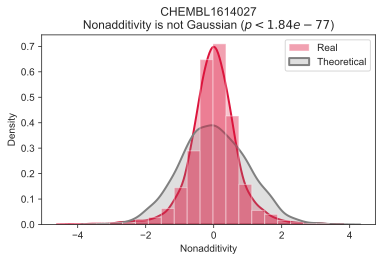

In [11]:
fig, ax = NA_distribution(MAIN['Nonadditivity'], significant_thrs)
ax.set_title(f'{assay_chembl_id}\n{ax.get_title()}')
# fig.savefig('nonadditivity_distribution.png', dpi=300)
plt.show()

In [12]:
PC['Nonadd_abs'] = PC['Nonadd_pC'].abs()
PC['CI']   = (2*2*exp_noise/(np.sqrt(PC['nOccurence'])))
PC['CI_2'] = (2*2*exp_noise/(np.sqrt(PC['nOccurence']))) * 3
PC = PC.sort_values(by=['CI'], ascending=False)
PC

,Compound_ID,SMILES,Series,Property,Operator,Measured,Nonadd_pC,nOccurence,Nonadd_SD,Nonadd_abs,CI,CI_2
0,CHEMBL1531070,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(C(F)(F)F)cc1)c1...,NaN,VALUE,NaN,5.1,-0.500000,1,0.00,0.500000,2.000000,6.000000
297,CHEMBL1568735,COc1cccc(-c2nc(=NCc3ccccc3OC)cc[nH]2)c1,NaN,VALUE,NaN,5.9,-1.800000,1,0.00,1.800000,2.000000,6.000000
281,CHEMBL1552519,c1ccc(CN=c2[nH]cnc3ccc(-c4ccoc4)cc23)cc1,NaN,VALUE,NaN,5.8,0.000047,1,0.00,0.000047,2.000000,6.000000
282,CHEMBL1370296,Cc1cccc(CN=c2[nH]cnc3ccc(-c4ccoc4)cc23)c1,NaN,VALUE,NaN,6.0,-0.000047,1,0.00,0.000047,2.000000,6.000000
283,CHEMBL491771,Cc1cccc(CN=c2[nH]cnc3ccc(-c4cccc(NS(C)(=O)=O)c...,NaN,VALUE,NaN,6.3,1.700000,1,0.00,1.700000,2.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
531,CHEMBL1490528,COCCn1c(=O)c(-c2cccs2)nc2cnc(N3CCNCC3)nc21,NaN,VALUE,NaN,5.7,0.310000,67,0.76,0.310000,0.244339,0.733017
464,CHEMBL1433704,COCCn1c(=O)c(-c2ccccc2)nc2cnc(Oc3ccccc3)nc21,NaN,VALUE,NaN,5.0,-0.210000,67,0.39,0.210000,0.244339,0.733017
428,CHEMBL1481510,O=c1c(-c2ccccc2)nc2cnc(N3CCNCC3)nc2n1C1CC1,NaN,VALUE,NaN,6.8,0.970000,67,0.84,0.970000,0.244339,0.733017
470,CHEMBL1472732,COCCn1c(=O)c(-c2ccccc2)nc2cnc(N3CCNCC3)nc21,NaN,VALUE,NaN,5.5,0.002900,69,0.68,0.002900,0.240772,0.722315


In [13]:
PC_log0 = PC[PC['Nonadd_pC'].abs() > add_thrs]
PC_log1 = PC[PC['Nonadd_pC'].abs() > significant_thrs]
PC_log2 = PC[PC['Nonadd_pC'].abs() > strong_thrs]

In [14]:
print(len(df.iloc[:,0]), 'compounds')
print(len(MAIN.iloc[:,0]), 'cycles')
print(len(MAIN_log1.iloc[:,0]), 'cycles with significant NA score', '(',round(len(MAIN_log1.iloc[:,0])/len(MAIN.iloc[:,0])*100,1), '% )')
print(len(PC_log1['Compound_ID'].value_counts()), 'unique compounds show significant NA shift', '(',round(len(PC_log1['Compound_ID'])/len(df.iloc[:,0])*100,1), '% )')
print(len(PC_log2['Compound_ID'].value_counts()), 'unique compounds show strong NA', '(',round(len(PC_log2['Compound_ID'])/len(df.iloc[:,0])*100,1), '% )')

2876 compounds
4086 cycles
486 cycles with significant NA score ( 11.9 % )
76 unique compounds show significant NA shift ( 2.6 % )
13 unique compounds show strong NA ( 0.5 % )


### Detect outliers

In [15]:
ambiguous_compounds = PC.loc[PC['Nonadd_pC'].abs() > PC['CI']]
ambiguous_compounds

,Compound_ID,SMILES,Series,Property,Operator,Measured,Nonadd_pC,nOccurence,Nonadd_SD,Nonadd_abs,CI,CI_2
862,CHEMBL1396862,O=S(=O)(c1ccccc1)N1CCC2(CCCN(Cc3ccncc3)C2)CC1,NaN,VALUE,NaN,7.1,2.80,1,0.000000e+00,2.80,2.000000,6.000000
863,CHEMBL1473753,O=S(=O)(c1ccccc1)N1CCC2(CCCN(c3ccncc3)C2)CC1,NaN,VALUE,NaN,5.4,-2.80,1,0.000000e+00,2.80,2.000000,6.000000
864,CHEMBL1553056,CS(=O)(=O)N1CCC2(CCCN(c3ccncc3)C2)CC1,NaN,VALUE,NaN,7.1,2.80,1,0.000000e+00,2.80,2.000000,6.000000
865,CHEMBL1435702,CS(=O)(=O)N1CCC2(CCCN(Cc3ccncc3)C2)CC1,NaN,VALUE,NaN,6.0,-2.80,1,0.000000e+00,2.80,2.000000,6.000000
612,CHEMBL1316759,COc1ncc2nc(C)c(=O)n(CCC#N)c2n1,NaN,VALUE,NaN,6.5,2.80,2,3.100000e-07,2.80,1.414214,4.242641
...,...,...,...,...,...,...,...,...,...,...,...,...
532,CHEMBL1554236,COCCn1c(=O)c(-c2cc(F)cc(F)c2)nc2cnc(N3CCNCC3)nc21,NaN,VALUE,NaN,5.9,0.66,63,7.800000e-01,0.66,0.251976,0.755929
447,CHEMBL1434801,O=c1c(CCc2ccccc2)nc2cnc(N3CCNCC3)nc2n1C1CC1,NaN,VALUE,NaN,5.0,-0.50,63,9.900000e-01,0.50,0.251976,0.755929
559,CHEMBL1405464,COc1cccc(Cn2c(=O)c(-c3cccs3)nc3cncnc32)c1,NaN,VALUE,NaN,5.6,0.36,64,7.600000e-01,0.36,0.250000,0.750000
531,CHEMBL1490528,COCCn1c(=O)c(-c2cccs2)nc2cnc(N3CCNCC3)nc21,NaN,VALUE,NaN,5.7,0.31,67,7.600000e-01,0.31,0.244339,0.733017


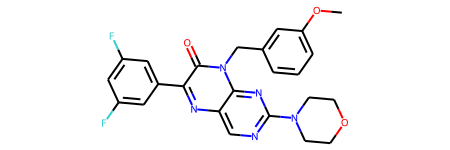

In [16]:
ambiguous_compounds = ambiguous_compounds.sort_values('Nonadd_abs')
SMILES = list(ambiguous_compounds['SMILES'])
strangest = SMILES[-2]

Chem.MolFromSmiles(strangest)

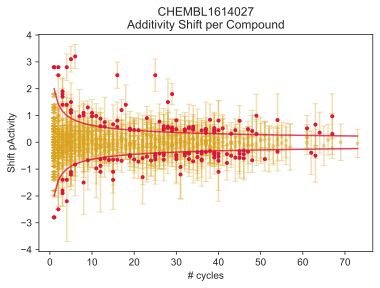

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel('# cycles')
ax.set_ylabel('Shift pActivity')
ax.set_title('Additivity Shift per Compound')

x = PC['nOccurence'].values
y = PC['Nonadd_pC'].values
e = PC['Nonadd_SD'].values
y_CI = PC['CI'].values
y_CI_2 = PC['CI_2'].values
x2 = ambiguous_compounds['nOccurence'].values
y2 = ambiguous_compounds['Nonadd_pC'].values
e2 = ambiguous_compounds['Nonadd_SD'].values

ax.errorbar(x, y, zorder=1, linestyle='None', yerr=e, alpha=0.35, capsize=3, color='goldenrod', marker='.')
ax.plot(x,y_CI, zorder=2, color='crimson', alpha=0.8, label= 'CI')
# plt.text(25, 0.3, 'CI', fontsize=23, color='crimson')
ax.plot(x,y_CI*(-1), zorder=3, color='crimson', alpha=0.8)
ax.errorbar(x2, y2, zorder=1, linestyle='None', capsize=3, color='crimson', marker='.')
ax.set_title(f'{assay_chembl_id}\n{ax.get_title()}')

plt.show()

### Check outliers 

1. value
2. measurement frequency

In [18]:
ambiguous_compounds = ambiguous_compounds[['Compound_ID', 'Measured', 'nOccurence', 'Nonadd_pC']]
ambiguous_compounds = ambiguous_compounds.rename(columns=({'Compound_ID':'ID'}))
ambiguous_compounds = pd.merge(ambiguous_compounds, df, on='ID')
ambiguous_compounds = ambiguous_compounds[['ID', 'VALUE', 'nOccurence', 'Nonadd_pC']]
ambiguous_compounds.head()

,ID,VALUE,nOccurence,Nonadd_pC
0,CHEMBL1490528,5.699992,67,0.31
1,CHEMBL1556431,4.899998,49,0.31
2,CHEMBL1513347,4.899998,46,-0.31
3,CHEMBL1590397,5.599998,43,0.32
4,CHEMBL1516787,5.299998,38,-0.33


/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


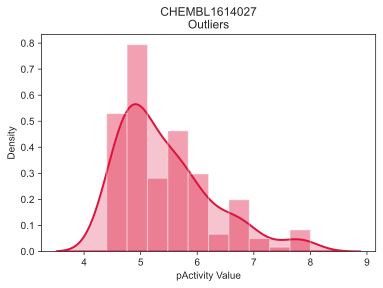

In [19]:
fig, ax = plot_outliers(ambiguous_compounds['VALUE'], 'Outliers')
ax.set_title(f'{assay_chembl_id}\n{ax.get_title()}')
plt.show()

### Compounds with Significant Additivity Shift
* significant = 2 times the experimental uncertainty

In [20]:
sign_NA_PC = PC_log1[['Compound_ID', 'Nonadd_pC']]
sign_NA_PC = sign_NA_PC.rename(columns=({'Compound_ID':'ID'}))
sign_NA_PC = pd.merge(sign_NA_PC, df, on='ID')
sign_NA_PC = sign_NA_PC[['ID', 'VALUE', 'Nonadd_pC']]

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


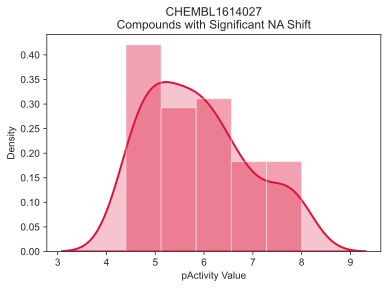

In [21]:
fig, ax = plot_outliers(sign_NA_PC['VALUE'], 'Compounds with Significant NA Shift')
ax.set_title(f'{assay_chembl_id}\n{ax.get_title()}')
plt.show()

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


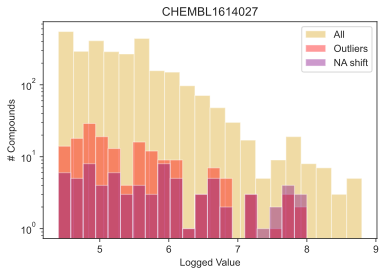

In [22]:
sns.set_style('ticks')
fig, ax = plt.subplots(1,1)
sns.distplot(df['VALUE'], hist=True, norm_hist=False, kde=False,
             bins=int(100/5), color='goldenrod',
             kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(ambiguous_compounds['VALUE'], hist=True, norm_hist=False, kde=False,
             color='red', bins=int(100/5),
             kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(sign_NA_PC['VALUE'], hist=True, norm_hist=False, kde=False,
             bins=int(100/5), color='purple',
             kde_kws={'shade': True, 'linewidth': 2})

legend = ['All','Outliers', 'NA shift']

plt.legend(legend)
plt.title(assay_chembl_id)
plt.xlabel('Logged Value')
plt.ylabel('# Compounds')
plt.yscale('log')
plt.show()

### Compounds with strong nonadditivity shift

* more than 2 times significance threshold

In [23]:
strong_NA_PC = PC_log2[['Compound_ID', 'Nonadd_pC']]
strong_NA_PC = strong_NA_PC.rename(columns=({'Compound_ID':'ID'}))
strong_NA_PC = pd.merge(strong_NA_PC, df, on='ID')
strong_NA_PC = strong_NA_PC[['ID', 'VALUE', 'Nonadd_pC', 'MEASUREMENT']]

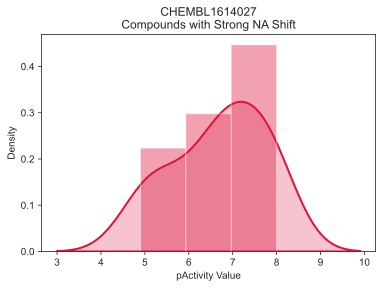

In [24]:
fig, ax = plot_outliers(strong_NA_PC['VALUE'], 'Compounds with Strong NA Shift')
ax.set_title(f'{assay_chembl_id}\n{ax.get_title()}')
plt.show()

### Double-mutant cycles

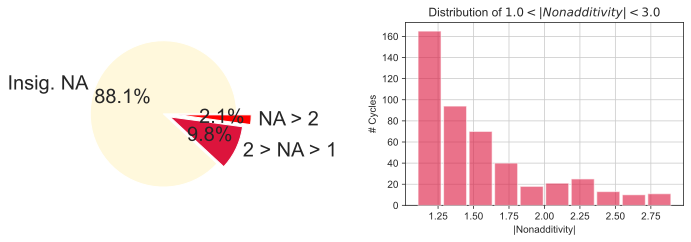

In [25]:
insignificant = len(MAIN.iloc[:,0]) - len(MAIN_log1.iloc[:,0])
treashold_1 = len(MAIN_log1.iloc[:,0]) - len(MAIN_log2.iloc[:,0])
treashold_2 = len(MAIN_log2.iloc[:,0])

fix, (lax, rax) = plt.subplots(1, 2, figsize=(10, 3.5))


labels = ["Insig. NA", "2 > NA > 1", "NA > 2"]   
sizes = [insignificant, treashold_1, treashold_2]
explode = [0,0.1,0.2]
colors = ['cornsilk', 'crimson', 'red']  

lax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 20})

upper_limit = 3.0
hist = MAIN_log1[MAIN_log1['Nonadditivity_abs'] < upper_limit]
hist.hist(column='Nonadditivity_abs', color='crimson', alpha=0.6, zorder=10, rwidth=0.9, ax=rax)

rax.set_title(f"Distribution of ${significant_thrs} < |Nonadditivity| < {upper_limit}$")
rax.set_xlabel("|Nonadditivity|")
rax.set_ylabel("# Cycles")
plt.tight_layout()

### NAA per compound

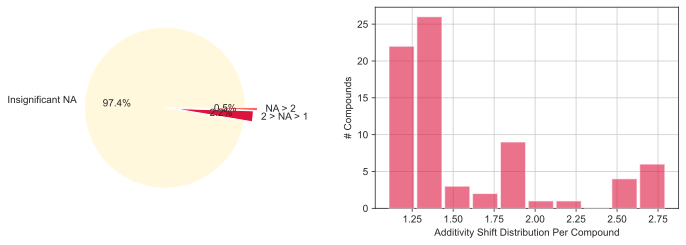

In [26]:
fig, (lax, rax) = plt.subplots(1, 2, figsize=(10, 3.5))

No_NA = len(df['ID'].value_counts()) - len(PC['Compound_ID'].value_counts())
No_significant =  len(PC['Compound_ID'].value_counts()) - len(PC_log1['Compound_ID'].value_counts()) + No_NA
treashold_1 = len(PC_log1['Compound_ID'].value_counts()) - len(PC_log2['Compound_ID'].value_counts())
treashold_2 = len(PC_log2['Compound_ID'].value_counts())

labels = ["Insignificant NA", "2 > NA > 1", "NA > 2"]   
sizes = [No_significant, treashold_1, treashold_2]
colors = ['cornsilk', 'crimson', 'red']
explode = [0,0.1,0.15]


lax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')

PC_hist = PC_log1[PC_log1['Nonadd_abs'] < 3]
PC_hist.hist(column= 'Nonadd_abs', color='crimson', alpha=0.6, zorder=10, rwidth=0.9, ax=rax)

rax.set_title("")
rax.set_xlabel("Additivity Shift Distribution Per Compound")
rax.set_ylabel("# Compounds")

fig.tight_layout()

### Plot images of highest NA score

* Code taken from https://github.com/KramerChristian/NonadditivityAnalysis

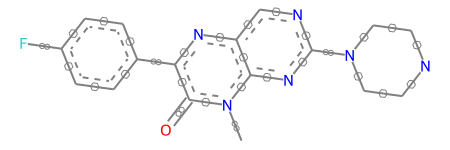

RDKit WARNING: [15:51:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:51:30] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [15:51:30] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:51:30] WARNING: not removing hydrogen atom with dummy atom neighbors


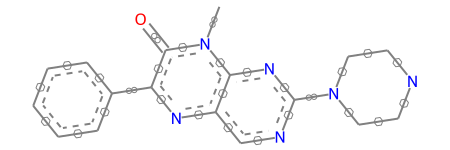

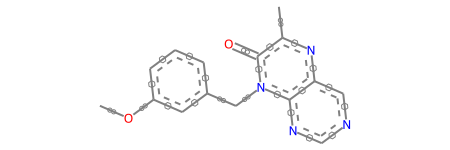

RDKit WARNING: [15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors


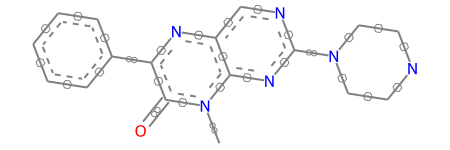

RDKit WARNING: [15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:51:35] WARNING: not removing hydrogen atom with dummy atom neighbors


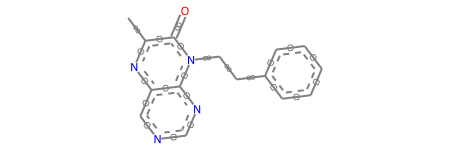

In [27]:
n_images = 5

highest_naa = MAIN.sort_values(by=['Nonadditivity_abs'], ascending=False).head(5)
highest_naa_tests = list(highest_naa.iloc[:n_images].values)

for c in highest_naa_tests:
    ids = c[0:4]
    ids = [str(i) for i in ids]
    smiles = c[4:8]
    tsmarts = c[9:11]
    pActs = c[12:16]
    pActs = [str(p) for p in pActs]
    Acts = ['']
    qualifiers = ['', '', '', '']
    nonadd = str(round(c[-1],1))
    target = c[8]

    cpds = [Chem.MolFromSmiles(smi) for smi in smiles]
    mcss_tot = Chem.MolFromSmarts(rdFMCS.FindMCS(cpds, completeRingsOnly=True, timeout=60).smartsString)
    AllChem.Compute2DCoords(mcss_tot)
    Chem.GetSymmSSSR(mcss_tot)
    display(mcss_tot)

    image_file = f'{assay_chembl_id}_image_' + str('-'.join(ids)) + '.png'
    draw_image(
        ids, smiles, tsmarts, pActs, Acts,
        qualifiers, nonadd, 
        mcss_tot=mcss_tot, image_file=image_file, target=target,
    )